In [332]:
import matplotlib.pyplot as plt
import xtrack as xt
import scipy as sc
import bpmeth
import sympy as sp
import math
import numpy as np
from cpymad.madx import Madx
from sympy.abc import alpha, beta  # Cool notebook greek letters!
import sys
import warnings
import nafflib


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2026.01.15 18:05:15      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ==== DRIFTS =====

q_drift        = 1.05;

mb_drift       = 0.2;

mb_quad_drift  = 0.15; // space mb2q + endcoils Q

sx_drift       = 0.5;

ss_drift       =  4.;



! ==== DIPOLE GEOMETRY ====

edge          = 30./180.*pi;

ein1          := edge;  

eout1         := edge;

fint	      = 0.42;

hgap          = 0.035;



phi            = 60./180.*pi;

rho            = 2.737;

mb_len        := phi*rho;



! ==== QUADRUPOLE STRENGTHS =====

quad_len       = 0.2;

qb_len         = 0.400;

qf_len         = 0.400;

qd_len         = 0.235;

sx_len         = 0.115;



mb_k1          = -0.11; 

qb_k1          = 2.8067743015574944;

qf_k1          = 2.6880579191671385;  

qd_k1          = -2.9440570148491068;



! ===

Converting sequence "he_ring": 100%|██████████| 73/73 [00:00<00:00, 1060.01it/s]


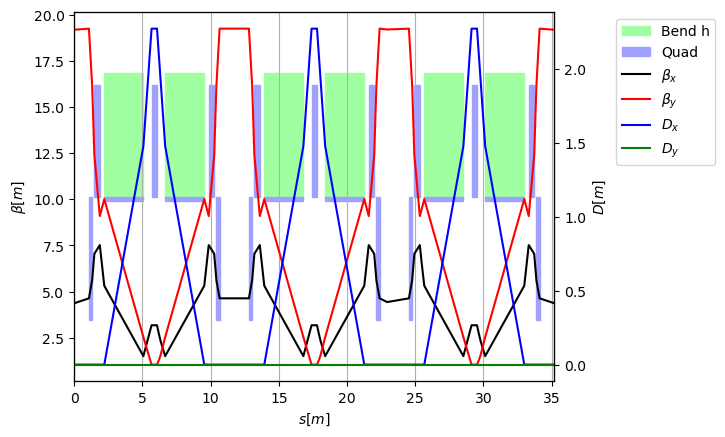

In [333]:
##################
# HeLICS lattice #
##################

mad=Madx()
mad.call("/home/silke/Documents/HeLICS/HeLICS.str")
mad.call("/home/silke/Documents/HeLICS/HeLICS.seq")
mad.beam()
mad.use("he_ring")

def match_tunes(madx,qx,qy):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    GLOBAL, Q2={qy},Q1={qx};
    vary, name=qd_k1, step=0.0000001;
    vary, name=qf_k1, step=0.0000001;
    simplex, calls=5000, tolerance=1E-10;
    endmatch;''')
    qf = madx.eval('qf_k1')
    qd = madx.eval('qd_k1')
    return qf,qd

def match_disp(madx):
    madx.input(f'''
    use, sequence=he_ring;
    MATCH;
    constraint, sequence=he_ring, range = "qf2b", DX=0.0;
    vary, name=qb_k1, step=0.0000001;
    jacobian, calls=5000, tolerance=1E-10;
    endmatch;''')
    qb = madx.eval('qb_k1') 
    return qb

print("Matched to Qx 2.4, Qy 1.2 with quadrupole strengths qf, qd = ", match_tunes(mad, 2.4, 1.2))

fringe="linear"

line=xt.Line.from_madx_sequence(mad.sequence.he_ring)
line.configure_bend_model(edge=fringe, core='adaptive', num_multipole_kicks=30)
line.particle_ref=xt.Particles(mass0=0.931494 * 4.001506179127e9, q0=2., energy0=(0.931494 * 4.001506179127 + 0.02)*1e9)  # Energy in eV, top energy
start_elem = "lssc"
line.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
    
tw0 = line.twiss4d()
tw0.plot()

### Track particles

3200 particles created


Text(0, 0.5, 'y [m]')

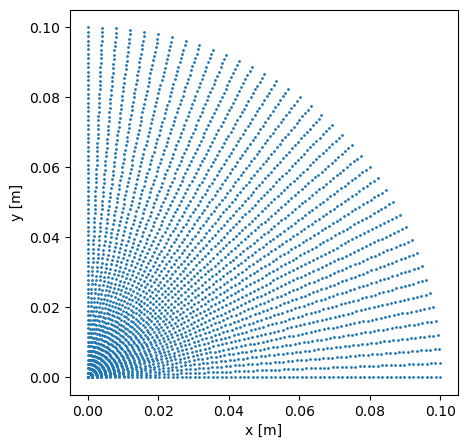

In [334]:
#############################
# Distribution of particles #
#############################

nr = 80
nphi = 40
n_part = nr * nphi
r = np.linspace(0, 0.1, nr)
phi = np.linspace(0, np.pi/2, nphi)

R, PHI = np.meshgrid(r, phi)
R = R.flatten()
PHI = PHI.flatten()

X = R * np.cos(PHI)
Y = R * np.sin(PHI)

part = line.build_particles(x = X, px = 0, y = Y, py = 0, zeta=0, delta=0)
print(f"{n_part} particles created")

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X, Y, s=1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

In [335]:
n_turn = 1000
line.track(part, num_turns=2*n_turn, turn_by_turn_monitor=True)
mon = line.record_last_track

In [336]:
x = mon.x
y = mon.y
px = mon.px
py = mon.py

np.savetxt(f"{fringe}fringe_tracking.txt", np.array([x.flatten(), y.flatten(), px.flatten(), py.flatten()]).T)

# plot Frequency Map Analysis

In [337]:
def calc_normalized_coords(x, px, betx=1, alphx=0):
    xn = x/np.sqrt(betx)
    pxn = (x*alphx/np.sqrt(betx) + px*np.sqrt(betx))
    return xn, pxn

In [338]:
xn, pxn = calc_normalized_coords(x, px, betx=tw0.betx[0], alphx=tw0.alfx[0])
hxm = xn - 1j*pxn
hxm1=hxm[:, :n_turn]  # First half of the data
hxm2=hxm[:, n_turn:]  # Second half of the data

yn, pyn = calc_normalized_coords(y, py, betx=tw0.bety[0], alphx=tw0.alfy[0])
hym = yn - 1j*pyn
hym1=hym[:, :n_turn]  # First half of the data
hym2=hym[:, n_turn:]  # Second half of the data

In [339]:
Qx1 = np.zeros(n_part)
Qx2 = np.zeros(n_part)
Qy1 = np.zeros(n_part)
Qy2 = np.zeros(n_part)

for i in range(n_part):
    Qx1[i] = nafflib.tune(hxm1[i], window_order=2, window_type="hann")
    Qx2[i] = nafflib.tune(hxm2[i], window_order=2, window_type="hann")
    Qy1[i] = nafflib.tune(hym1[i], window_order=2, window_type="hann")
    Qy2[i] = nafflib.tune(hym2[i], window_order=2, window_type="hann")
    

In [340]:
def tunediff(Q1, Q2):
    """ Tune described over interval [-0.5, 0.5] """
    return np.min(np.array([np.abs(Q2 - Q1), 1 - np.abs(Q2 - Q1)]), axis=0)
    

In [341]:
Qx = 0.5 * (Qx1 + Qx2)
Qy = 0.5 * (Qy1 + Qy2)

dQ = np.log10(np.sqrt((tunediff(Qx1, Qx2))**2 + tunediff(Qy1, Qy2)**2))

### Save plot data

In [342]:
np.savetxt(f"FMA_{fringe}fringe.txt", np.array([X, Y, Qx, Qy, dQ]).T, header="x [m], y [m], Qx, Qy, log10(sqrt(dQx**2 + dQy**2))")

### Plot stuff

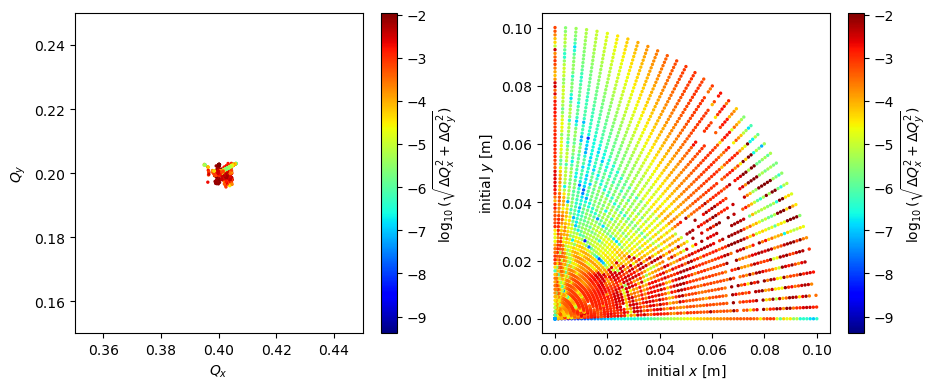

In [355]:
fringe="linear"
X, Y, Qx, Qy, dQ = np.loadtxt(f"FMA_{fringe}fringe.txt", unpack=True)

fig, ax = plt.subplots(1, 2, figsize=(9.5, 4))

sc1 = ax[0].scatter(
    Qx, Qy,
    c=dQ,
    s=2,
    cmap="jet",
    rasterized=True
)

sc2 = plt.scatter(
    X, Y,
    c=dQ,
    s=2,
    cmap="jet",
    rasterized=True
)

plt.xlabel("initial x")
plt.ylabel("initial y")

ax[0].set_xlabel(r"$Q_x$")
ax[0].set_ylabel(r"$Q_y$")

ax[1].set_xlabel(r"initial $x$ [m]")
ax[1].set_ylabel(r"initial $y$ [m]")

ax[0].set_xlim(0.35, 0.45)
ax[0].set_ylim(0.15, 0.25)

fig.colorbar(sc1, label=r"$\log_{10}(\sqrt{\Delta Q_x^2 + \Delta Q_y^2})$", ax=ax[0])
fig.colorbar(sc2, label=r"$\log_{10}(\sqrt{\Delta Q_x^2 + \Delta Q_y^2})$", ax=ax[1])
fig.tight_layout()
plt.show()


### Spectrum

Clear resonance line at $Q_x = 2 Q_y$

In [277]:
def plot_spectrum(hxm, ax):
    hfmin = np.fft.fft(hxm)
    hfminabs = np.abs(hfmin)
    hfminabs = np.fft.fftshift(hfminabs)        
    ff = np.fft.fftfreq(len(hxm))
    ff = np.fft.fftshift(ff)
    ax.plot(ff, np.log(hfminabs))

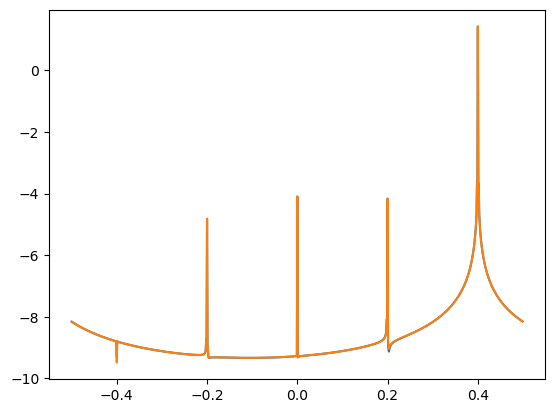

In [ ]:
fig, ax = plt.subplots()
plot_spectrum(hxm1[5], ax)
plot_spectrum(hxm2[5], ax)